# Import Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from wordcloud import WordCloud
from lib_file import lib_path
from sklearn.utils import resample
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
lemmatizer = WordNetLemmatizer()
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Loading

In [5]:
df = pd.read_csv("input/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


# Data Preprocessing

In [6]:
df = df[["reviews.text", 'reviews.rating']]
df.head()

,reviews.text,reviews.rating
0,I order 3 of them and one of the item is bad q...,3
1,Bulk is always the less expensive way to go fo...,4
2,Well they are not Duracell but for the price i...,5
3,Seem to work as well as name brand batteries a...,5
4,These batteries are very long lasting the pric...,5


In [7]:
df.isnull().sum()

reviews.text      0
reviews.rating    0
dtype: int64

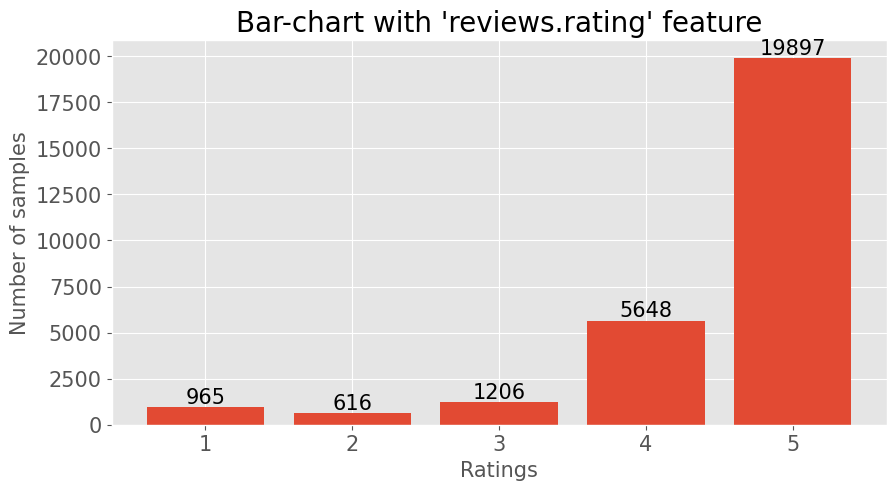

In [8]:
chart_data = dict(df['reviews.rating'].value_counts())
with plt.style.context(style="ggplot"):
    plt.figure(figsize=(10,5))
    plt.rcParams['font.size'] = 15
    plt.bar(x=list(chart_data.keys()),
           height=list(chart_data.values()))
    plt.title(label="Bar-chart with 'reviews.rating' feature", fontsize=20)
    plt.xlabel(xlabel="Ratings", fontsize=15)
    plt.ylabel(ylabel="Number of samples", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    for x, y in zip(chart_data.keys(), chart_data.values()):
        plt.text(x, y, str(y), ha='center', va='bottom')
    plt.show()

In [9]:
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if not char.isdigit()])
    text = ''.join([char for char in text if char not in string.punctuation])
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    porter_stemmer = PorterStemmer()
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(lemmatized_words)
    return cleaned_text

In [10]:
%%time
df['cleaned_text'] = df['reviews.text'].apply(clean_text)

CPU times: user 20 s, sys: 61.1 ms, total: 20 s
Wall time: 20.3 s


In [11]:
df.head()

,reviews.text,reviews.rating,cleaned_text
0,I order 3 of them and one of the item is bad q...,3,order one item bad quality missing backup spri...
1,Bulk is always the less expensive way to go fo...,4,bulk always le expensive way go product like
2,Well they are not Duracell but for the price i...,5,well duracell price happy
3,Seem to work as well as name brand batteries a...,5,seem work well name brand battery much better ...
4,These batteries are very long lasting the pric...,5,battery long lasting price great


In [12]:
df['reviews.rating'].value_counts()

5    19897
4     5648
3     1206
1      965
2      616
Name: reviews.rating, dtype: int64

In [13]:
df['sentiment'] = df['reviews.rating'].apply(lambda x: 'positive' if x>=4 else 'negative')
df.head()

,reviews.text,reviews.rating,cleaned_text,sentiment
0,I order 3 of them and one of the item is bad q...,3,order one item bad quality missing backup spri...,negative
1,Bulk is always the less expensive way to go fo...,4,bulk always le expensive way go product like,positive
2,Well they are not Duracell but for the price i...,5,well duracell price happy,positive
3,Seem to work as well as name brand batteries a...,5,seem work well name brand battery much better ...,positive
4,These batteries are very long lasting the pric...,5,battery long lasting price great,positive


In [14]:
df = df.drop(labels='reviews.rating', axis=1)
df.head()

,reviews.text,cleaned_text,sentiment
0,I order 3 of them and one of the item is bad q...,order one item bad quality missing backup spri...,negative
1,Bulk is always the less expensive way to go fo...,bulk always le expensive way go product like,positive
2,Well they are not Duracell but for the price i...,well duracell price happy,positive
3,Seem to work as well as name brand batteries a...,seem work well name brand battery much better ...,positive
4,These batteries are very long lasting the pric...,battery long lasting price great,positive


In [15]:
df['sentiment'].value_counts()

positive    25545
negative     2787
Name: sentiment, dtype: int64

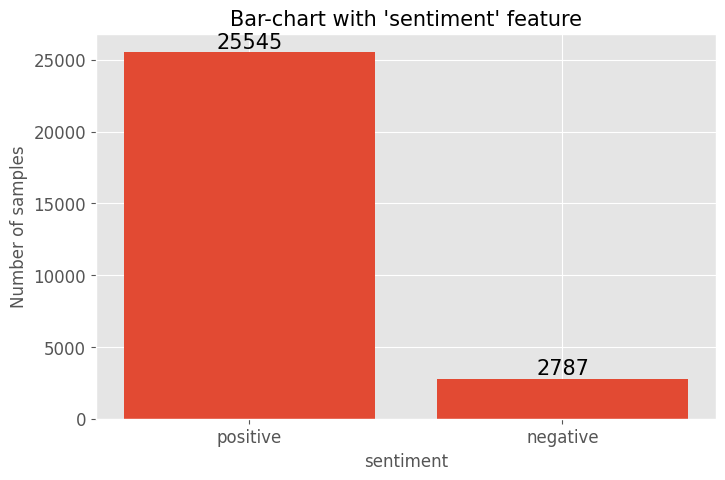

In [16]:
chart_data = dict(df['sentiment'].value_counts())
with plt.style.context(style="ggplot"):
    plt.figure(figsize=(8,5))
    plt.rcParams['font.size'] = 15
    plt.bar(x=list(chart_data.keys()),
           height=list(chart_data.values()))
    plt.title(label="Bar-chart with 'sentiment' feature", fontsize=15)
    plt.xlabel(xlabel="sentiment", fontsize=12)
    plt.ylabel(ylabel="Number of samples", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for x, y in zip(chart_data.keys(), chart_data.values()):
        plt.text(x, y, str(y), ha='center', va='bottom')
    plt.show()

In [17]:
df['sequence_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df.head()

,reviews.text,cleaned_text,sentiment,sequence_length
0,I order 3 of them and one of the item is bad q...,order one item bad quality missing backup spri...,negative,14
1,Bulk is always the less expensive way to go fo...,bulk always le expensive way go product like,positive,8
2,Well they are not Duracell but for the price i...,well duracell price happy,positive,4
3,Seem to work as well as name brand batteries a...,seem work well name brand battery much better ...,positive,9
4,These batteries are very long lasting the pric...,battery long lasting price great,positive,5


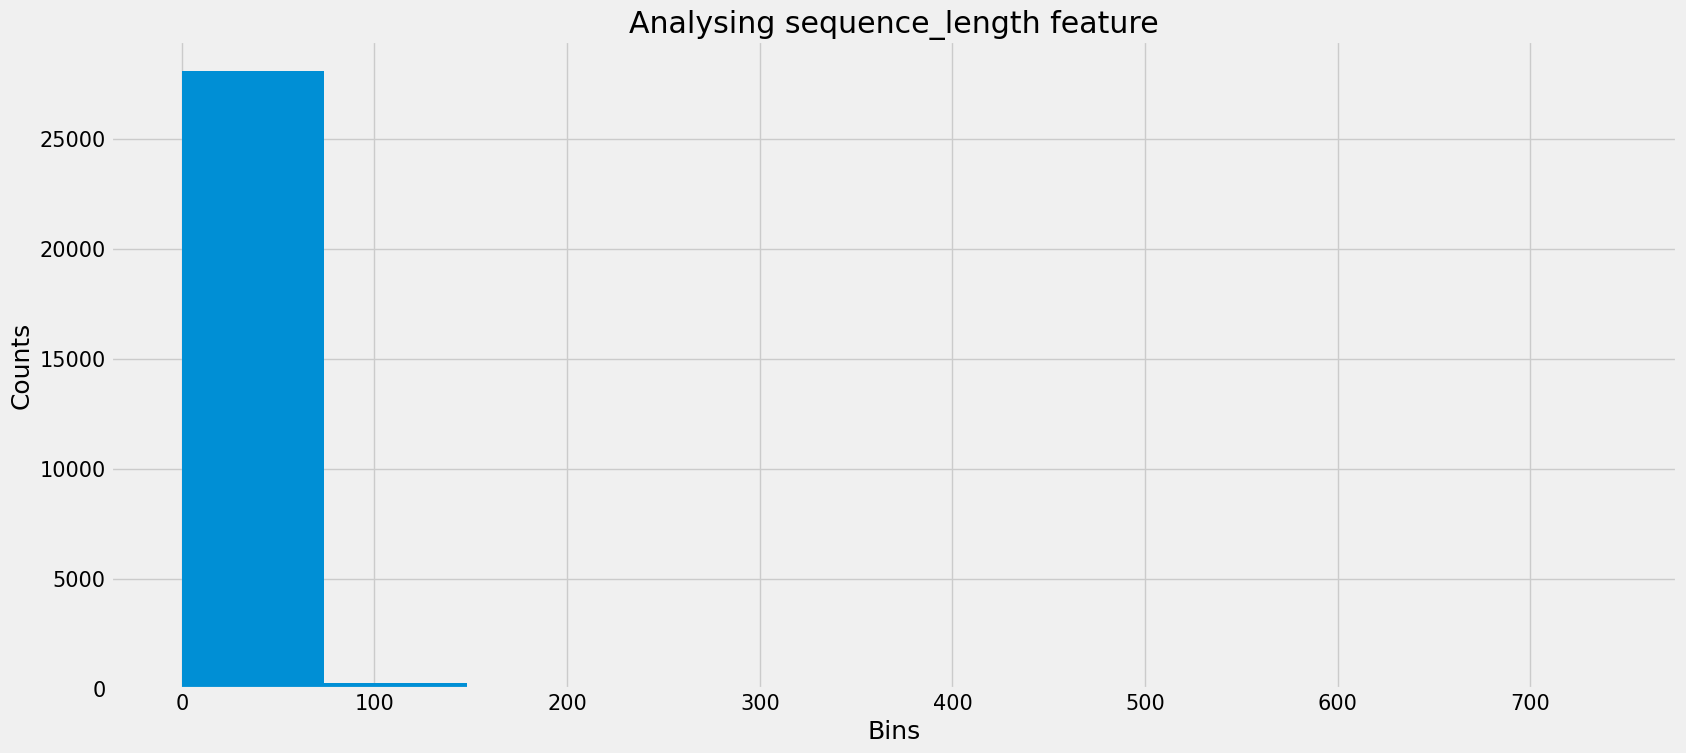

In [18]:
with plt.style.context(style="fivethirtyeight"):
    plt.rcParams['font.size'] = 15
    df['sequence_length'].hist(figsize=(18,8))
    plt.title(label="Analysing sequence_length feature")
    plt.xlabel(xlabel="Bins")
    plt.ylabel(ylabel="Counts")
    plt.show()

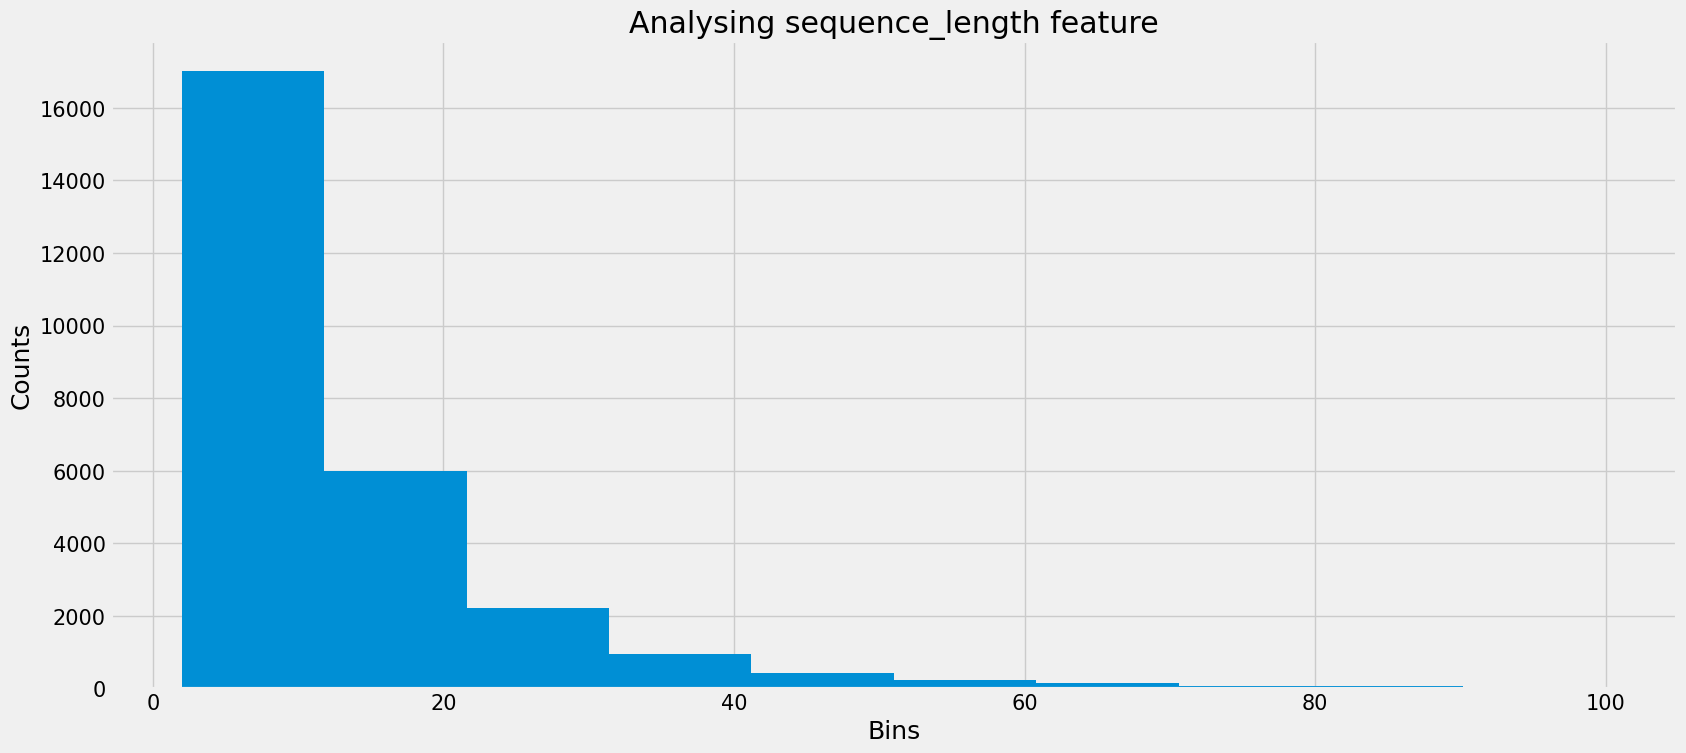

In [19]:
df = df.loc[(df['sequence_length'] <= 100) & (df['sequence_length'] >= 2)]

with plt.style.context(style="fivethirtyeight"):
    plt.rcParams['font.size'] = 15
    df['sequence_length'].hist(figsize=(18,8))
    plt.title(label="Analysing sequence_length feature")
    plt.xlabel(xlabel="Bins")
    plt.ylabel(ylabel="Counts")
    plt.show()

In [20]:
df1 = df.loc[df['sentiment']=='positive'][:5000]
df2 = df.loc[df['sentiment']=='negative']

df = pd.concat(objs=[df1, df2], ignore_index=True)
df.shape

(7704, 4)

In [21]:
df['sentiment'].value_counts()

positive    5000
negative    2704
Name: sentiment, dtype: int64

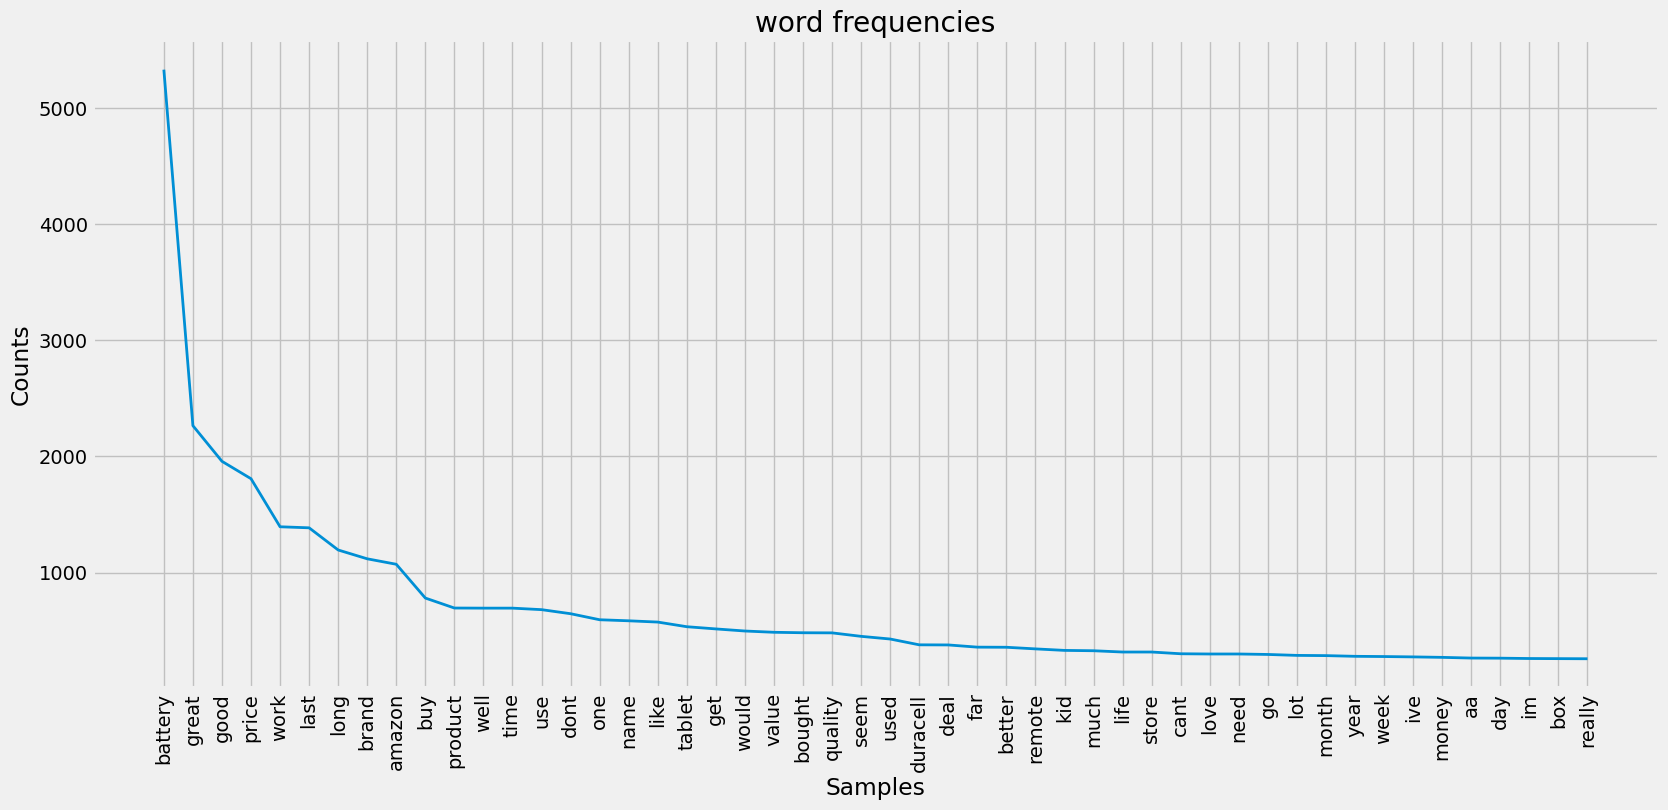

In [22]:
text_data = ' '.join(df['cleaned_text'].astype(str))
words = word_tokenize(text_data)
word_freq = FreqDist(words)

with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(18, 8))
    word_freq.plot(50, cumulative=False, title='word frequencies')
    plt.show()

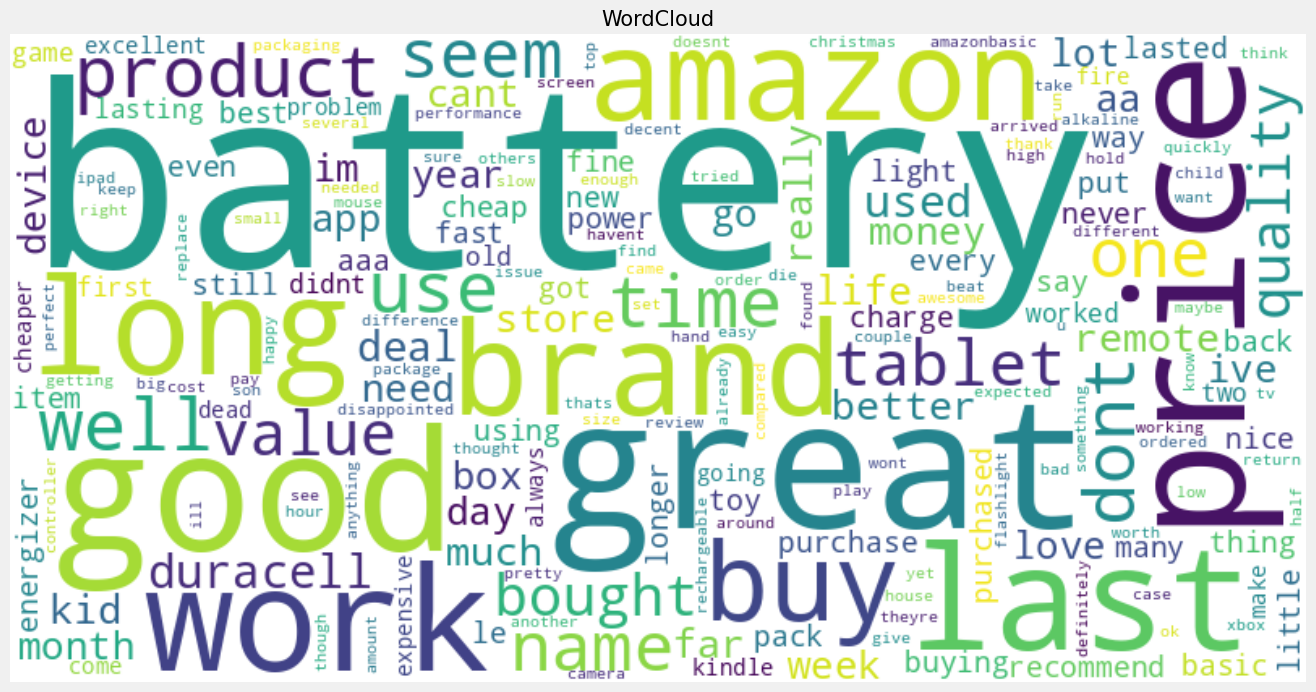

In [23]:
with plt.style.context(style="fivethirtyeight"):
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_data)
    plt.figure(figsize=(18, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label="WordCloud", fontsize=15)
    plt.axis('off')
    plt.show()

In [24]:
df.head()

,reviews.text,cleaned_text,sentiment,sequence_length
0,Bulk is always the less expensive way to go fo...,bulk always le expensive way go product like,positive,8
1,Well they are not Duracell but for the price i...,well duracell price happy,positive,4
2,Seem to work as well as name brand batteries a...,seem work well name brand battery much better ...,positive,9
3,These batteries are very long lasting the pric...,battery long lasting price great,positive,5
4,Bought a lot of batteries for Christmas and th...,bought lot battery christmas amazonbasics cell...,positive,23


In [25]:
df = df[['cleaned_text', 'sentiment']]
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,cleaned_text,sentiment
0,great value toss duracell procell bulk battery...,positive
1,like fifth box battery last long longer others...,positive
2,seems equal brand battery used,positive
3,ran aa battery course came amazon purchase tig...,positive
4,amazon battery high quality,positive


In [26]:
resampled = []
for target in df['sentiment'].unique().tolist():
    running_df = df.loc[df['sentiment']==target]
    resampled.append(resample(running_df, n_samples=5000))

data = pd.concat(objs=resampled, ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)

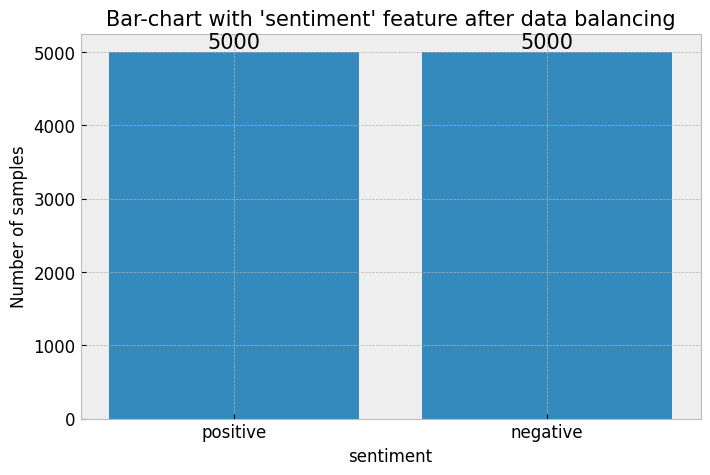

In [27]:
chart_data = dict(data['sentiment'].value_counts())
with plt.style.context(style="bmh"):
    plt.figure(figsize=(8,5))
    plt.rcParams['font.size'] = 15
    plt.bar(x=list(chart_data.keys()),
           height=list(chart_data.values()))
    plt.title(label="Bar-chart with 'sentiment' feature after data balancing", fontsize=15)
    plt.xlabel(xlabel="sentiment", fontsize=12)
    plt.ylabel(ylabel="Number of samples", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for x, y in zip(chart_data.keys(), chart_data.values()):
        plt.text(x, y, str(y), ha='center', va='bottom')
    plt.show()

In [28]:
data.to_csv("processed_data.csv", index=False)